# CS171-EE142 - Fall 2021 - Homework 3

# Due: Monday, November 15, 2021 @ 11:59pm (tentative)

### Maximum points: 80 pts


## Submit your solution to Gradescope:
1. Submit screenshot images or a single PDF to **HW3**
2. Submit your jupyter notebook to **HW3-code**


### Enter your information below:

<div style="color: #000000;background-color: #EEEEFF">
    Your Name (submitter):  Hsiangwei Hsiao<br>
    Your student ID (submitter): 862254811
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>


## Academic Integrity
Each assignment should be done  individually. You may discuss general approaches with other students in the class, and ask questions to the TAs, but  you must only submit work that is yours . If you receive help by any external sources (other than the TA and the instructor), you must properly credit those sources, and if the help is significant, the appropriate grade reduction will be applied. If you fail to do so, the instructor and the TAs are obligated to take the appropriate actions outlined at http://conduct.ucr.edu/policies/academicintegrity.html . Please read carefully the UCR academic integrity policies included in the link.


# Overview 
In this assignment you will implement a two-layer neural network. You will implement the loss functions, gradients, optimizers to train the network and test its performance on MNIST dataset. 

For this assignment we will use the functionality of Pandas (https://pandas.pydata.org/), Matplotlib (https://matplotlib.org/), and Numpy (http://www.numpy.org/). 

If you are asked to **implement** a particular functionality, you should **not** use an existing implementation from the libraries above (or some other library that you may find). When in doubt, please ask. 

Before you start, make sure you have installed all those packages in your local Jupyter instance

## Read *all* cells carefully and answer all parts (both text and missing code)

You will complete all the code marked `TODO` and answer descriptive/derivation questions 



In [494]:
import numpy as np
import matplotlib.pyplot as plt

# make sure you import here everything else you may need

### Load MNIST Dataset 

For this assignment, we will use [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digits data set. The dataset consists 10 handwritten digits (0,1,...,9). It is a widely used dataset to demonstrate simple image classification problem.

MNIST dataset is publicly available from different sources. We will be using MNIST from Keras package. If you do not have Keras installed, you can find the installation guide [here](https://www.tutorialspoint.com/keras/keras_installation.htm). 

In short, you need to run ```conda install -c anaconda keras``` or ```pip install keras```

The training data consists of 60000 images of size $28 \times 28$ pixels; the test data consists of 10000 images.

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


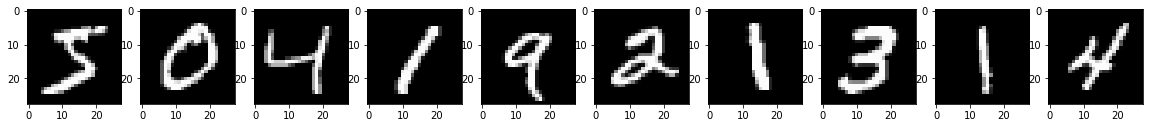

In [495]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training data shape:',x_train.shape)
print('Test data shape:',x_test.shape)

n_img=10
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
    plt.subplot(1,n_img,i+1)
    plt.imshow(x_train[i])
plt.show()

We will be vectorizing the training and test images. So, the size of each vector will be 784.

In [496]:
x_train=x_train.reshape(x_train.shape[0],-1)
x_test=x_test.reshape(x_test.shape[0],-1)

print('Training data shape after reshaping:',x_train.shape)
print('Test data shape after reshaping::',x_test.shape)

Training data shape after reshaping: (60000, 784)
Test data shape after reshaping:: (10000, 784)


## Question 1a: Binary classification using neural network [45 pts]

We will start with classification of images for two different digits using a two-layer network with a cross entropy loss. 

In the next question, we will extend the same architecture to multi-class classification. 

Pick any two digits out of ten for our classification (say 5 and 8), which we will assign label "0" or "1". 

Pick same number of images from each class for training and create arrays for input and output (say 1000). 

```
# train_x -- N x 784 array of training input
# train_y -- N x 1 array of binary labels 
```  

If you use 1000 images from each class N = 2000. You can increase the number of training samples if you like. It is just a suggestion. 


We also need to transpose the dimension of the data so that their size becomes $784\times N$. It will be helpful to feed it to our model based on our notations.


In [497]:
def extract_binary_classification_dataset(x, y, label1, label2, num_samples):
    """Make a subset dataset from MNIST, containing only 2 classes for binary classification task 
    Args:
        x (numpy.ndarray): data, can be x_train or x_test
        y (numpy.ndarray): labels of data, can be y_train or y_test
        label1 (int): the first class you pick, e.g. 5
        label2 (int): the second class you pick, e.g. 8
        num_samples (int): the number of images you select for each class, e.g. 1000
    Returns:
        x_ (numpy.ndarray): the data for 2 picked classes
        y_ (numpy.ndarray): the corresponding labels for 2 picked classes
    """
    # for class 1
    x1 = x[y == label1]
    x1 = x1[:num_samples]
    y1 = np.zeros(len(x1))

    # for class 2
    x2 = x[y == label2]
    x2 = x2[:num_samples]
    y2 = np.ones(len(x2))

    # combine 2 classes
    x_ = np.concatenate((x1,x2),axis=0)
    y_ = np.concatenate((y1,y2),axis=0)
    return x_, y_


# Pick your own digits
label1 = 2
label2 = 3
num_samples = 1000

# Train & test data
train_x, train_y = extract_binary_classification_dataset(x_train, y_train, label1, label2, num_samples)
test_x, test_y = extract_binary_classification_dataset(x_test, y_test, label1, label2, num_samples)

# reshape data 
train_x = train_x.T
test_x = test_x.T
print("Training data shape:", train_x.shape)
print("Test data shape:", test_x.shape)

Training data shape: (784, 2000)
Test data shape: (784, 2000)


### Network Architecture

We will be using a two layer neural network in our experiment. The input layer will have 784 nodes, the hidden layer will have 256 nodes and the output layer will have 1 node. Each node will have $\textit{sigmoid}$ activation function.

The equations for feedforward operation will be the following:

$$\mathbf{z}^{(1)}=W^{(1)} \mathbf{x}+ \mathbf{b}^{(1)}\\\mathbf{y}^{(1)}=\varphi(\mathbf{z}^{(1)})\\\mathbf{z}^{(2)}=W^{(2)}  \mathbf{y}^{(1)}+ \mathbf{b}^{(2)} \\\mathbf{y}^{(2)}=\varphi(\mathbf{z}^{(2)})$$

where $\mathbf{x}\in \mathbb{R}^{784}$ is the input layer, $\mathbf{y}^{(1)}\in \mathbb{R}^{256}$ is the hidden layer, $\mathbf{y}^{(2)} \in \mathbb{R}$ is the output layer, $W^{(1)}\in \mathbb{R}^{256\times 784}$ is the first layer weights, $W^{(2)}\in \mathbb{R}^{1\times 256}$ is the second layer weights, $\mathbf{b}^{(1)}\in \mathbb{R}^{256}$ is the first layer bias, $\mathbf{b}^{(2)}\in \mathbb{R}$ is the second layer bias, $\varphi(\cdot)$ is the activation function.

### Network initialization [5 pts]

We initialize the weights for $W^{(1)}$ and $W^{(2)}$ with random values drawn from normal distribution with zero mean and 0.01 standard deviation. We will initialize bias vectors $\mathbf{b}^{(1)}$ and $\mathbf{b^{(2)}}$ with zero values. 

We can fix the seed for random initialization for reproducibility.

In [499]:
def TwoLayerNetwork(layer_dims=[784,256,1]):
    # Fix the seed
    np.random.seed(5)

    # TODO 
    # Your code goes here
    w1 = np.random.normal(0, 0.01, size=(256,784))
    w2 = np.random.normal(0, 0.01, size=(1,256))
    b1 = np.zeros((256,1))
    b2 = np.zeros((1,1))
    params = [w1, w2, b1, b2]
    return params

### Sigmoid activation function 
Now we will write the sigmoid activation function as 

$$ \varphi(z) = \frac{1}{1+e^{-z}}$$

Note that derivative of __sigmoid__ is $\varphi'(z) = \varphi(z) (1-\varphi(z))$. 

In [500]:
def sigmoid(Z):
    # Input: Z -- numpy.ndarray
    # TODO 
    # Write your function
    Y = 1 / (1 + np.exp(-Z))
    
    return Y

### Cross entropy loss function [5 pts]
We will minimize the binary cross entropy loss function. You will use the true labels and predicted labels of a batch of N samples. 

Binary crossentropy loss for $i^{th}$ sample can be written as 

$$Loss_i = -y_i \log y^{(2)}_i- (1-y_i) \log (1-y^{(2)}_i)$$

where $y_i$ is the true label. We can find the average loss for a batch of N samples as $Loss=\frac{1}{N}\sum_{i=1}^{N} Loss_i$.

Note that the gradient of the cross entropy loss w.r.t. the output is 

$$ \nabla_{y^{(2)}} Loss_i = -\frac{y_i}{y_i^{(2)}} + \frac{1-y_i}{1-y_i^{(2)}} = \frac{y_i^{(2)}-y_i}{y_i^{(2)}(1-y_i^{(2)})}.$$

We can also show that $$\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i  = \nabla_{y^{(2)}} Loss_i \odot \varphi'(\mathbf{z})= y_i^{(2)}-y_i.$$ 

In [501]:
def CrossEntropyLoss(Y_true, Y2):
    # TODO 
    # Write your code here
    loss = -Y_true*np.log(Y2) - (1-Y_true)*np.log(1-Y2)
    return loss

### Forward propagation  [5 pts]
Next, we will write the code for the forward pass for two layer network. Each layer consists of an affine function (fully-connected layer) followed by an activation function. You wil also return the intermediate results ($\mathbf{x}, \mathbf{z}^{(1)}, \mathbf{y}^{(1)}, \mathbf{z}^{(2)}$) in addition to final output ($\mathbf{y}^{(2)}$). You will need the intermediate outputs for the backpropagation step.

In [502]:
def forward(X, params):
    # TODO 
    # Write your codes here
    # X -- 784 x N array 
    # params -- 
      # W1 -- 256 x 784 matrix
      # b1 -- 256 x 1 vector
      # W2 -- 1 x 256 matrix
      # b2 -- 1 x 1 scalar 
    # Y2 -- 1 x N output
    z1 = np.dot(params[0], X) + params[2]
    y1 = sigmoid(z1)
    z2 = np.dot(params[1], y1) + params[3]
    Y2 = sigmoid(z2)
    intermediate = [X, z1, y1, z2]
    return Y2, intermediate

### Backpropagration step [10 pts]
Now we will implement the backpropagation step for the two layer neural network. 

You will need the gradient of the Loss w.r.t. $W^{(l)},\mathbf{b}^{(l)}$ for $l = 1,2$ for all the training samples.  



We saw that we can write the gradient of Loss with respect to $W^{(l)}, \mathbf{b}^{(l)}$ for a single sample as

$$\nabla_{W^{(l)}} Loss_i = \delta^{(l)} \mathbf{y}^{(l-1)T},$$  
$$\nabla_{\mathbf{b}^{(l)}} Loss_i = \delta^{(l)},$$

where 
$$\delta^{(l)} = \nabla_{\mathbf{z}^{(l)}} Loss_i = \nabla_{\mathbf{y}^{(l)}} Loss_i \odot \varphi'(\mathbf{z}^{(l)}).$$ 


For the the last layer, we can compute $\delta^{(L)}$ by plugging the value of $\nabla_{\mathbf{y}^{(L)}} Loss$ as described above. 

For the intermediate layers $l<L$, we can write 
$$\delta^{(l)} = W^{(l+1)T}\delta^{(l+1)} \odot \varphi'(\mathbf{z}^{(l)}).$$ 



**Once we have the gradients $\nabla_{W^{(l)}} Loss_i, \nabla_{\mathbf{b}^{(l)}} Loss_i$ for all $i$. We can compute their average to compute the gradient of the total loss function as**

$$\nabla_{W^{(l)}} Loss = \frac{1}{N} \sum_i \nabla_{W^{(l)}} Loss_i, $$
$$ \nabla_{\mathbf{b}^{(l)}} Loss = \frac{1}{N} \sum_i  \nabla_{\mathbf{b}^{(l)}} Loss_i.$$

**Please refer to the slides and lectures for more details.**

In [503]:
def backward(X, Y_true, Y2, intermediate, params):
    # Inputs: 
      # Y_true -- 1 x N true labels
      # Y2 -- 1 x N output of the last layer
      # intermediate -- X, Z1, Y1, Z2 
      # params = [w1, w2, b1, b2]
    # Outputs: 
      # grads -- [grad_W1, grad_b1, grad_W2, grad_b2]
    
    # TODO 
    # Write your codes here
    x_transpose = np.transpose(X)
    sigma2 = Y2-Y_true
    sigma1 = np.dot(params[1].T, sigma2)*sigmoid(intermediate[1])*(1-sigmoid(intermediate[1]))
    grad_W1 = np.dot(sigma1, x_transpose)
    grad_b1 = sigma1
    y1_transpose = np.transpose(intermediate[2])
    # sigma2 = Y2-Y_true
    grad_W2 = np.dot(sigma2, y1_transpose)
    grad_b2 = sigma2
    grads = [grad_W1, grad_b1, grad_W2, grad_b2] 
          
    return grads

### Optimizer [5 pts]
We will use a standard gradient descent-based optimizer to minimize the loss function. You have already implemented gradient descent in HW2. You may have to adjust learning rate that provides you best training/validation performance. In this exercise, we are not using validation data; in practice, you should use it to tune your hyperparameters such as learning rate, network architecture etc.

You can use same learning rate for all weights in this assignment. 

You should update $W^1, \mathbf{b}^1, W^2, \mathbf{b}^2$ as 
$$ W^1 \gets W^1 - \alpha \nabla_{W^1} Loss $$
$$ \mathbf{b}^1 \gets \mathbf{b}^1 - \alpha \nabla_{\mathbf{b}^1} Loss $$ 
$$ W^2 \gets W^2 - \alpha \nabla_{W^2} Loss $$ 
$$ \mathbf{b}^2 \gets \mathbf{b}^2 - \alpha \nabla_{\mathbf{b}^2} Loss $$ 
$\alpha$ is the learning rate. 

In [504]:
def GD(params, grads, learning_rate):
    
    # updated params = old params - learning rate * gradient of Loss computed at old params
    # params = [w1, w2, b1, b2]
    # grads = [grad_W1, grad_b1, grad_W2, grad_b2]
    # TODO 
    # Write your codes here
    params[0] = params[0] - learning_rate*grads[0]
    params[2] = params[2] - learning_rate*grads[1]
    params[1] = params[1] - learning_rate*grads[2]
    params[3] = params[3] - learning_rate*grads[3]
     
        
    return params

### Train the Model [5 pts]
We will train the model using the functions we wrote above. 

First, we specify the number of nodes in the layers, number of epochs and learning rate. Then we initialize the network.

In [510]:
layer_dims = [train_x.shape[0],256,1] #Input_layer/Hidden_layer/Output_layer
epochs = 500
lr = 0.00001

params = TwoLayerNetwork(layer_dims)

Then we train the network for the number of epochs specified above. In every epoch, we will do the following:
1. Calculate the forward pass to get estimated labels.
2. Use the estimated labels calculate loss. We will be recording loss for every epoch.
3. Use backpropagation to calculate gradients.
4. Use gradient descent to update the weights and biases.

You should store the loss value after every epoch in an array ```loss_history```  and print the loss value after every few epochs (say 20). 


In [511]:
# TODO 
# Write your codes here
# intermediate = [X, z1, y1, z2]
N = 2000

params = TwoLayerNetwork(layer_dims)
loss_history = []
for i in range(epochs):
  Y2, intermediate = forward(train_x, params) # Get the eastimated labels
  loss = CrossEntropyLoss(train_y, Y2) # Calculate the loss between true label and eastimated labels
  loss = sum(loss[0])/N
  loss_history.append(loss)
  grads = backward(train_x, train_y, Y2, intermediate, params)
  params = GD(params, grads, lr)
  if i%20 == 0:
    print("Each 20 epochs's loss: ", loss)
# print(loss_history)

Each 20 epochs's loss:  0.70170207369227
Each 20 epochs's loss:  0.27330464866626525
Each 20 epochs's loss:  0.14468246747999158
Each 20 epochs's loss:  0.10210978339787671
Each 20 epochs's loss:  0.08108720310270225
Each 20 epochs's loss:  0.06837814844190869
Each 20 epochs's loss:  0.05998203199999045
Each 20 epochs's loss:  0.05397300473726519
Each 20 epochs's loss:  0.04967339273489249
Each 20 epochs's loss:  0.04638484565776715
Each 20 epochs's loss:  0.04366383847693154
Each 20 epochs's loss:  0.04135116598835351
Each 20 epochs's loss:  0.03945102029657855
Each 20 epochs's loss:  0.03779839376829518
Each 20 epochs's loss:  0.03639975581218044
Each 20 epochs's loss:  0.035240370356433216
Each 20 epochs's loss:  0.03410781785256526
Each 20 epochs's loss:  0.03304525299378053
Each 20 epochs's loss:  0.032130425624693794
Each 20 epochs's loss:  0.03119767296266562
Each 20 epochs's loss:  0.030432054283530883
Each 20 epochs's loss:  0.029730766247740608
Each 20 epochs's loss:  0.02898

Now we will plot the recorded loss values vs epochs. We will observe the training loss decreasing with the epochs.

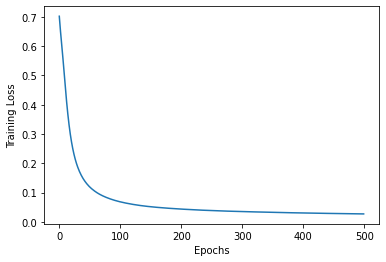

In [512]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

### Evaluation on test data [5 pts]

Now we will be evaluating the accuracy we get from the trained model. We feed training data and test data to the forward model along with the trained parameters. 

Note that, we need to covert the output probability of the forward pass to binary labels before evaluating accuracy. Since the model provides the posterior probability $p(y = 1 | x)$ in range [0,1]. We can binarize them using 0.5 as a theshold (i.e. if $y_i^{(2)}\geq 0.5$, $y_i^{(2)} \gets 1$ otherwise  $y_i^{(2)} \gets 0$).

In [513]:
# TODO 
Y_theshold = []
for x in Y2[0]:
  if x >= 0.5:
    Y_theshold.append(1)
  else:
    Y_theshold.append(0)

print("Training accuracy:",np.mean(Y_theshold==train_y))

Y2_test, intermediate = forward(test_x, params)
Y_test_theshould = []
for i in Y2_test[0]:
  if i >= 0.5:
    Y_test_theshould.append(1)
  else:
    Y_test_theshould.append(0)


print("Test accuracy:",np.mean(Y_test_theshould==test_y))

Training accuracy: 0.991
Test accuracy: 0.9765


### Visualize some of the correct/miscalassified images [5 pts]

Now we will look at some images from training and test sets that were misclassified. 

Training set. 
Pick 5 images from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives

Test set. 
Pick 5 images from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives


Training set examples for true/false positive/negative
Correct images


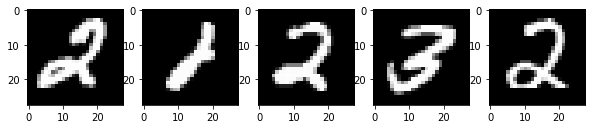

Incorrect images


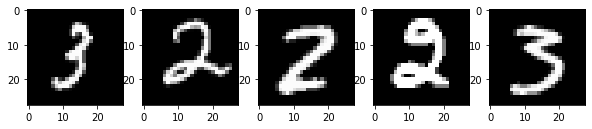

In [515]:
import random
# TODO 
# Training set
print("Training set examples for true/false positive/negative")
Y_hat, caches = forward(train_x, params)

# your code goes here...
Y_hat_theshould = []
for i in Y_hat[0]:
  if i >= 0.5:
    Y_hat_theshould.append(1)
  else:
    Y_hat_theshould.append(0)


corr_list = []
incorr_list = []
count = 0
for i in Y_theshold==train_y:
  count += 1
  if i == 1:
    corr_list.append(count)
  else:
    incorr_list.append(count)

n_img=5
train_x_fig = train_x.T
train_x_fig = train_x_fig.reshape(2000,28,28)

# correct images
print("Correct images")
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
  x = random.randrange(i,len(corr_list))
  plt.subplot(1,n_img,i+1)
  plt.imshow(train_x_fig[corr_list[x]])
plt.show()

# incorrect images
print("Incorrect images")
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
  x = random.randrange(i,len(incorr_list))
  plt.subplot(1,n_img,i+1)
  plt.imshow(train_x_fig[incorr_list[x]])
plt.show()

Test set examples for true/false positive/negative
Correct images


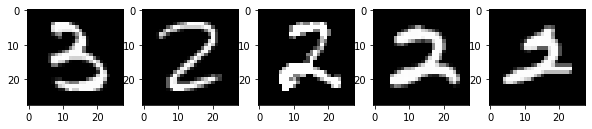

Incorrect images


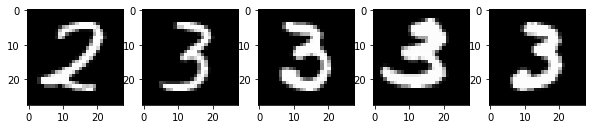

In [516]:
# Test set
print("Test set examples for true/false positive/negative")
Y_hat, caches = forward(test_x, params)

# your code goes here... 
Y_hat_theshould = []
for i in Y_hat[0]:
  if i >= 0.5:
    Y_hat_theshould.append(1)
  else:
    Y_hat_theshould.append(0)


corr_list = []
incorr_list = []
count = 0
for i in Y_hat_theshould==test_y:
  count += 1
  if i == 1:
    corr_list.append(count)
  else:
    incorr_list.append(count)

n_img=5

test_x_fig = test_x.T
test_x_fig = test_x_fig.reshape(2000,28,28)

# correct images
print("Correct images")
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
  x = random.randrange(i,len(corr_list))
  plt.subplot(1,n_img,i+1)
  plt.imshow(test_x_fig[corr_list[x]])
plt.show()

# incorrect images
print("Incorrect images")
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
  x = random.randrange(i,len(incorr_list))
  plt.subplot(1,n_img,i+1)
  plt.imshow(test_x_fig[incorr_list[x]])
plt.show()



---



## Question 1b. Multiclass classification [35 pts] 

Now we will build a classifier to separate all the digits. For this purpose, we will only change the last layer and the loss. 


Instead of using a single output, we will provide 10 outputs; and instead of using a binary cross entropy loss, we will use mutli-class cross entropy loss. 

In multinomal logistic regression (aka softmax regression), we define the posterior probability of label $y \in \{0,\ldots, K-1\}$ as 


$$p(y = c | \mathbf{x}) = \frac{\exp(\mathbf{w}_c^T\mathbf{x})}{\sum_{k=1}^K \exp(\mathbf{w}_k^T\mathbf{x})} = \mathbf{p}_c.$$ 

In other words, last layer of the network provides a probability vector $\mathbf{p} \in \mathbb{R}^K$, such that each $0 \le \mathbf{p}_c \le 1$ and $\sum_c \mathbf{p}_c = 1$. 

### Softmax function [5 pts]

Let us first define the softmax function, which is a multinomal extension of the sigmoid function that maps a vector of length $K$ to a probability vector. 

We can define ```softmax``` function on a vector $\mathbf{z} \in \mathbb{R}^K$ as $\mathbf{p} = \text{softmax}(\mathbf{z})$: 

$$\mathbf{p}_c(\mathbf{z}) = \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)}$$



In [530]:
def softmax(Z):
    # Z -- K x N numpy.ndarray, K is the number of classes, N is the number of samples
    # TODO  
    # your code goes here... 
    probs = np.exp(Z)
    probs /= np.sum(probs,axis=0,keepdims=True)
    
    return probs

We have to note that the numerical range of floating point numbers in numpy is limited. For `float64` the upper bound is $10^{308}$. For exponential, its not difficult to overshoot that limit, in which case python returns `nan`.

To make our softmax function numerically stable, we simply normalize the values in the vector, by multiplying the numerator and denominator with a constant `C` as

\begin{align*}
\mathbf{p}_c  &= \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)} \\
& = \frac{C\exp(\mathbf{z}_c)}{C\sum_{k=1}^K \exp(\mathbf{z}_k)}\\
& = \frac{\exp(\mathbf{z}_c + \log C)}{C\sum_{k=1}^K \exp(\mathbf{z}_k + \log C)}.
\end{align*}

We can choose an arbitrary value for `log(C)` term, but generally `log(C) = −max(z)` is chosen


In [531]:
def stable_softmax(Z): 
    # Z -- K x N numpy.ndarray, K is the number of classes, N is the number of samples
    # TODO (this is optional)
    # your code goes here
    probs = np.exp(Z-max(Z))/(pow(10,-max(Z))*sum(np.exp(Z-max(Z)))) 


    return probs

### Derivative of the softmax function

We can show that the derivative of the __softmax__ function with respect to any input can be written as 

$$ \frac{\partial \mathbf{p}_i}{\partial \mathbf{z}_j} = \begin{cases} \mathbf{p}_i(1-\mathbf{p}_j) & i = j \\ \mathbf{p}_i (-\mathbf{p}_j) & i \ne j. \end{cases}$$

[More info here](https://deepnotes.io/softmax-crossentropy)


### Multiclass cross entropy loss function [5 pts]

We will minimize the cross entropy loss. You will use the true labels and predicted labels of a batch of N samples. 

The multi-class cross entropy loss for $i^{th}$ sample can be written as 
$$Loss_i = -\sum_c \mathbf{1}(y_i = c) \log \mathbf{p}_c $$
where $y_i$ is the true label and 

$$\mathbf{1}(y_i = c) = \begin{cases} 1 & y_i =c \\ 0 & \text{otherwise} \end{cases}$$ 
is an indicator function. 

We can find the average loss for a batch of N samples as $Loss=\frac{1}{N}\sum_{i=1}^{N} Loss_i$. 


In [532]:
def MultiClassCrossEntropyLoss(Y_true, probs):
  
  # TODO 
  # Write your code here

  # probs -- K x N array
  # Y_true -- 1 x N array 
  # loss --  sum Loss_i over N samples 
  loss = np.zeros([1, len(Y_true)])
  for i in range(len(Y_true)):
    P_ = probs[int(Y_true[i]), i]
    loss[0,i] = -np.log(P_+1e-7)
  loss = np.mean(loss)

  return loss

### Derivative of the cross entropy loss 

Let us assume that $\mathbf{p} = \text{softmax}(\mathbf{z})$. 

Note that the derivative of the loss w.r.t. $\mathbf{p}_j$ can be written as 
$$\frac{\partial Loss_i }{\partial \mathbf{p}_j} = \begin{cases} -1/\mathbf{p}_j & j = y_i \\ 0 & j \ne y_i \end{cases}. $$

Note that we can use _total derivative_ to compute the derivative of the loss for $i$th sample w.r.t. $j$th entry in $\mathbf{z}$ as

\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} = \sum_c \frac{\partial Loss_i}{\partial \mathbf{p}_c}\frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j}.
\end{align*}

From our discussion above, we know that the $\frac{\partial Loss_i}{\partial \mathbf{p}_c} = 0$ if $c \ne y_i$. 


\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} &= -\frac{1}{\mathbf{p}_c} \frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j} \\
& = \begin{cases} \mathbf{p}_j - 1 & j = y_i \\ \mathbf{p}_j & j \ne y_i. \end{cases}
\end{align*}

Therefore, $$\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i}.$$

where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$. 


### Training data

Let us pick training data for multi-class classification. 

Pick same number of images from each class for training and create arrays for input and output. 

```
# train_x -- N x 784 array of training input
# train_y -- N x 1 array of binary labels 
```  

If you use 1000 images from each class N = 10000. You can increase the number of training samples if you like. You may also use unequal number of images in each class. 

We also need to transpose the dimension of the data so that their size becomes $784\times N$. It will be helpful to feed it to our model based on our notations.

In [533]:
# Pick training samples 
num_samples = 1000

# Train data
x = np.zeros((0,784))
y = np.zeros((0))
for label in range(10):
  x1 = x_train[y_train == label]  
  x1 = x1[:num_samples]
  y1 = y_train[y_train == label]
  y1 = y1[:num_samples]
  
  x = np.concatenate((x,x1),axis=0)
  y = np.concatenate((y,y1),axis=0)

train_x = x
train_y = y
print("Training data shape:", train_x.shape)


# Test data
test_x = x_test
test_y = y_test 
print("Test data shape:", test_x.shape)

# reshape data 
train_x = train_x.T
test_x = test_x.T
print("Training data shape:", train_x.shape) 
print("Test data shape:", test_x.shape)

Training data shape: (10000, 784)
Test data shape: (10000, 784)
Training data shape: (784, 10000)
Test data shape: (784, 10000)


### Network Architecture

We will be using a two layer neural network in our experiment. The input layer has 784 nodes, the hidden layer will have 256 nodes and the output layer will have 10 nodes. First layer will have __sigmoid__ activation and second layer will have __softmax__ activation.

The equations for feedforward operation will be as follows.

$$\mathbf{z}^{(1)}=W^{(1)} \mathbf{x}+ \mathbf{b}^{(1)}\\\mathbf{y}^{(1)}=\text{sigmoid}(\mathbf{z}^{(1)})\\\mathbf{z}^{(2)}=W^{(2)}  \mathbf{y}^{(1)}+ \mathbf{b}^{(2)} \\\mathbf{p} = \mathbf{y}^{(2)}=\text{softmax}(\mathbf{z}^{(2)})$$

where $\mathbf{x}\in \mathbb{R}^{784}$ is the input layer, $\mathbf{y}^{(1)}\in \mathbb{R}^{256}$ is the hidden layer, $\mathbf{y}^{(2)} \in \mathbb{R}$ is the output layer, $W^{(1)}\in \mathbb{R}^{256\times 784}$ is the first layer weights, $W^{(2)}\in \mathbb{R}^{10\times 256}$ is the second layer weights, $\mathbf{b}^{(1)}\in \mathbb{R}^{256}$ is the first layer bias, $\mathbf{b}^{(2)}\in \mathbb{R}^{10}$ is the second layer bias vector.

### Network initialization [5 pts]

We initialize the weights for $W^{(1)}$ and $W^{(2)}$ with random values drawn from normal distribution with zero mean and 0.01 standard deviation. We will initialize bias vectors $\mathbf{b}^{(1)}$ and $\mathbf{b^{(2)}}$ with zero values. 

We can fix the seed for random initialization for reproducibility.

In [534]:
def TwoLayerNetwork(layer_dims=[784,256,10]):
    # TODO 
    # Your code goes here

    # Fix the seed
    np.random.seed(3)
    
    #Initialize the weights
    w1 = np.random.normal(0, 0.01, size=(256,784))
    w2 = np.random.normal(0, 0.01, size=(10,256))
    b1 = np.zeros((256,1))
    b2 = np.zeros((10,1))
    params = [w1, w2, b1, b2]
     
    return params

### Forward propagation 
Next, we will write the code for the forward pass for two layer network. Each layer consists of an affine function (fully-connected layer) followed by an activation function. You wil also return the intermediate results ($\mathbf{x}, \mathbf{z}^{(1)}, \mathbf{y}^{(1)}, \mathbf{z}^{(2)}$) in addition to final output ($\mathbf{y}^{(2)}$). You will need the intermediate outputs for the backpropagation step.

In [535]:
def forward(X, params):
    
    # TODO 
    # Write your codes here

    # X -- 784 x N array 
    # params = [w1, w2, b1, b2]
    # params -- 
      # W1 -- 256 x 784 matrix
      # b1 -- 256 x 1 vector
      # W2 -- 10 x 256 matrix
      # b2 -- 10 x 1 scalar 
    # probs -- 10 x N output
    z1 = np.dot(params[0], X) + params[2]
    y1 = sigmoid(z1)
    z2 = np.dot(params[1], y1) + params[3]
    probs = softmax(z2)
    intermediate = [X, z1, y1, z2] 
 

    return probs, intermediate

### Backpropagration step [10 pts]

Now we will implement the backpropagation step for the two layer neural network using softmax layer and loss function. 


You will need the gradient of the Loss w.r.t. $W^{(l)},\mathbf{b}^{(l)}$ for $l = 1,2$ for all the training samples.  

We saw that we can write the gradient of Loss with respect to $W^{(l)}, \mathbf{b}^{(l)}$ for a single sample as

$$\nabla_{W^{(l)}} Loss_i = \delta^{(l)} \mathbf{y}^{(l-1)T},$$  
$$\nabla_{\mathbf{b}^{(l)}} Loss_i = \delta^{(l)},$$


where 
$$\delta^{(l)} = \nabla_{\mathbf{z}^{(l)}} Loss = \nabla_{\mathbf{y}^{(l)}} Loss \odot \varphi'(\mathbf{z}^{(l)}).$$ 

We saw above that for an $i$th sample, $\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i},$ where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$ and $\mathbf{p}$ is the outpu probability vector for the $i$th sample. 


**Once we have the gradients $\nabla_{W^{(l)}} Loss_i, \nabla_{\mathbf{b}^{(l)}} Loss_i$ for all $i$. We can compute their average to compute the gradient of the total loss function as**

$$\nabla_{W^{(l)}} Loss = \frac{1}{N} \sum_i \nabla_{W^{(l)}} Loss_i, $$
$$ \nabla_{\mathbf{b}^{(l)}} Loss = \frac{1}{N} \sum_i  \nabla_{\mathbf{b}^{(l)}} Loss_i.$$

**Please refer to the slides and lectures for more details.**

In [536]:
def backward(X, Y_true, probs, intermediate, params):
    
    # Inputs: 
      # Y_true -- true labels
      # probs -- 10 x N output of the last layer
      # intermediate -- X, Z1, Y1, Z2 
      # params = [w1, w2, b1, b2] 
    
    # Outputs: 
      # grads -- [grad_W1, grad_b1, grad_W2, grad_b2]
    
    # TODO 
    # Write your codes here
    x_transpose = np.transpose(X)
    Y_onehot = np.zeros(probs.shape)
    for i in range(probs.shape[1]):
      Y_onehot[int(Y_true[i]), i] = 1
    
    sigma2 = probs - Y_onehot

    sigma1 = np.dot(params[1].T, sigma2)*sigmoid(intermediate[1])*(1-sigmoid(intermediate[1]))

    grad_W1 = np.dot(sigma1, x_transpose)
    grad_b1 = sigma1
    y1_transpose = np.transpose(intermediate[2])

    
    # sigma2 = probs - Y_onehot
    grad_W2 = np.dot(sigma2, y1_transpose)
    grad_b2 = sigma2
    grads = [grad_W1, grad_b1, grad_W2, grad_b2] 
          
    return grads

In [537]:
def GD(params, grads, learning_rate):
    
    # updated params = old params - learning rate * gradient of Loss computed at old params
    # params = [w1, w2, b1, b2]
    # grads = [grad_W1, grad_b1, grad_W2, grad_b2]
    # TODO 
    # Write your codes here
    params[0] = params[0] - learning_rate*grads[0]
    params[2] = params[2] - learning_rate*grads[1]
    params[1] = params[1] - learning_rate*grads[2]
    params[3] = params[3] - learning_rate*grads[3]
     
        
    return params

### Train the model [5 pts]
We will use the forward and backward functions defined above with the same optimizer defined in the previous question to train our multi-class classificaiton model. 

We will specify the number of nodes in the layers, number of epochs and learning rate and initialize the network

In [543]:
layer_dims = [train_x.shape[0],256,10]
epochs = 500
lr = 0.00001

params = TwoLayerNetwork(layer_dims)

Then we train the network for the number of epochs specified above. In every epoch, we will do the following:
1. Calculate the forward pass to get estimated labels.
2. Use the estimated labels calculate loss. We will be recording loss for every epoch.
3. Use backpropagation to calculate gradients.
4. Use gradient descent to update the weights and biases.

You should store the loss value after every epoch in an array ```loss_history```  and print the loss value after every few epochs (say 20). 


In [544]:
# TODO 
# Write your codes here
N = 10000
loss_history = []
for i in range(epochs):
  probs, intermediate = forward(train_x, params) # Get the eastimated labels
  loss = MultiClassCrossEntropyLoss(train_y, probs) # Calculate the loss between true label and eastimated labels
  loss_history.append(loss)
  grads = backward(train_x, train_y, probs, intermediate, params)
  params = GD(params, grads, lr)
  if i%20 == 0:
    print("Each 20 epochs's loss: ", loss)
# print(loss_history)

Each 20 epochs's loss:  2.3156495881686125
Each 20 epochs's loss:  0.8567738070290352
Each 20 epochs's loss:  0.49819508075800095
Each 20 epochs's loss:  0.32787515006338047
Each 20 epochs's loss:  0.27290561055009555
Each 20 epochs's loss:  0.34285421129902127
Each 20 epochs's loss:  0.24185762048038478
Each 20 epochs's loss:  0.19401080246863622
Each 20 epochs's loss:  0.15589841312161365
Each 20 epochs's loss:  0.14101662098827059
Each 20 epochs's loss:  0.1364897453095593
Each 20 epochs's loss:  0.17445843369683967
Each 20 epochs's loss:  0.13216300119683416
Each 20 epochs's loss:  0.10778375591754089
Each 20 epochs's loss:  0.09163766230644374
Each 20 epochs's loss:  0.14947273134225522
Each 20 epochs's loss:  0.08170888243398643
Each 20 epochs's loss:  0.07737960297827902
Each 20 epochs's loss:  0.07851503718582524
Each 20 epochs's loss:  0.07088872009305176
Each 20 epochs's loss:  0.06849697357342953
Each 20 epochs's loss:  0.06531545928181022
Each 20 epochs's loss:  0.066655706

Now we will plot the recorded loss values vs epochs. We will observe the training loss decreasing with the epochs.

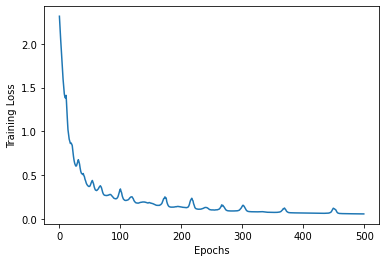

In [545]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

### Evaluation on test data [5 pts]

Now we will be evaluating the accuracy we get from the trained model. We feed training data and test data to the forward model along with the trained parameters. 

Note that, we need to convert the (probability) output of the forward pass into labels before evaluating accuracy. We can assign label based on the maximum probability. 

We assign estimated labels $$\hat{y}_i = \arg \max_c  \mathbf{p}_c $$ for every probility vector. 

In [546]:
# TODO  
probs_east_lab = np.argmax(probs, axis=0)

print("Training accuracy:",np.mean(probs_east_lab==train_y))

probs_test, intermediate = forward(test_x, params)

probs_test_east_lab = np.argmax(probs, axis=0)
test_y_sorted = sorted(test_y)
print("Test accuracy:",np.mean(probs_test_east_lab == test_y_sorted))


Training accuracy: 0.9878
Test accuracy: 0.9247


### Visualize some of the correct/miscalassified images [optional]

Now we will look at some images from training and test sets that were misclassified. 

Training set. 
Pick example from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives

Test set. 
Pick examples from each class that are correcly and incorreclty classified. 
True/False Positive/Negatives


Training set examples for true/false positive/negative
Correct images


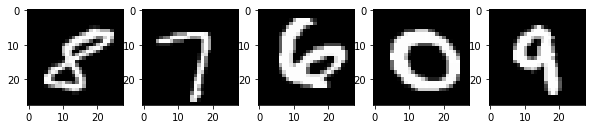

Incorrect images


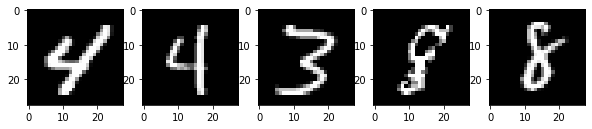

In [548]:
import random
# TODO 
# Your code goes here ...
# Training set
print("Training set examples for true/false positive/negative")
P1, caches = forward(train_x, params)

# your code goes here...
P1 = np.argmax(P1, axis=0)

corr_list = []
incorr_list = []
count = 0
for i in P1==train_y:
  count += 1
  if i == 1:
    corr_list.append(count)
  else:
    incorr_list.append(count)

n_img=5

train_x_fig = train_x.T
train_x_fig = train_x_fig.reshape(10000,28,28)

# correct images
print("Correct images")
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
  x = random.randrange(i,len(corr_list))
  plt.subplot(1,n_img,i+1)
  plt.imshow(train_x_fig[corr_list[x]])
plt.show()

# incorrect images
print("Incorrect images")
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
  x = random.randrange(i,len(incorr_list))
  plt.subplot(1,n_img,i+1)
  plt.imshow(train_x_fig[incorr_list[x]])
plt.show()


Training set examples for true/false positive/negative
Correct images


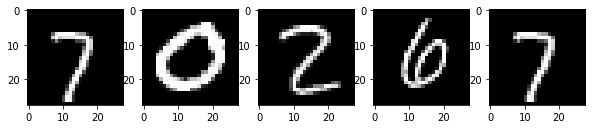

Incorrect images


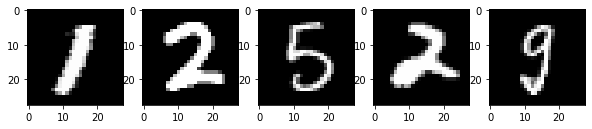

In [549]:
import random
# TODO 
# Your code goes here ...
# Training set
print("Training set examples for true/false positive/negative")
P2, caches = forward(test_x, params)

# your code goes here...
P2 = np.argmax(P2, axis=0)
test_y = sorted(test_y)

corr_list = []
incorr_list = []
count = 0
for i in P2==test_y:
  count += 1
  if i == 1:
    corr_list.append(count)
  else:
    incorr_list.append(count)

n_img=5

test_x_fig = test_x.T
test_x_fig = test_x_fig.reshape(10000,28,28)

# correct images
print("Correct images")
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
  x = random.randrange(i,len(corr_list))
  plt.subplot(1,n_img,i+1)
  plt.imshow(test_x_fig[corr_list[x]])
plt.show()

# incorrect images
print("Incorrect images")
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
  x = random.randrange(i,len(incorr_list))
  plt.subplot(1,n_img,i+1)
  plt.imshow(test_x_fig[incorr_list[x]])
plt.show()
